[프로젝트 보고서] Semantic Segmentation 모델 성능 비교 분석
1. 개요
본 프로젝트는 자율주행 연구의 핵심인 Semantic Segmentation(시맨틱 세그멘테이션) 기술을 실습하는 것을 목표로 합니다. KITTI 데이터셋을 활용하여 도로 영역을 분할하는 과제를 수행하였으며, 기본적인 U-Net 모델과 이를 개선한 U-Net++ 모델을 직접 구현하고 성능을 비교 분석하였습니다.

**기준 1: U-Net을 통한 세그멘테이션 작업 진행**
- 데이터셋 구축: KITTI 데이터셋을 불러와 학습용(Train)과 테스트용(Test)으로 나누고, DataLoader를 통해 모델에 입력 가능한 형태로 전처리를 완료했습니다.
- 모델 학습: 기본적인 Encoder-Decoder 구조를 가진 U-Net 모델을 정의하고, 정상적으로 학습 루프(Training Loop)를 수행했습니다.
-결과 시각화: 학습된 모델이 도로 영역을 어떻게 예측했는지 시각화하여, 입력 이미지와 정답(Ground Truth) 마스크와 비교하는 전체 파이프라인을 완성했습니다.

**기준 2: U-Net++ 모델 구현**
- 구조적 개선: 기존 U-Net의 긴 Skip Connection 사이의 빈 공간(Semantic Gap)을 메우기 위해, **Dense Convolution Block(조밀한 합성곱 블록)**과 **Nested Skip Pathways(중첩된 스킵 경로)**를 도입한 U-Net++ 아키텍처를 직접 코드로 구현했습니다.
- 문제 해결: 구현 과정에서 발생한 채널 수 불일치 문제(Dimension Mismatch)를 해결하고, 안정적인 학습을 완료했습니다.
- 학습 진행: U-Net과 동일한 조건에서 학습을 진행하여 공정한 비교 기반을 마련했습니다.

**기준 3: U-Net과 U-Net++ 모델의 성능 비교 (정량/정성)**
1) 정량적 평가 (수치 비교) 두 모델의 성능을 객관적으로 비교하기 위해 두 가지 지표를 사용했습니다.
- IoU (Intersection over Union): 전체적인 면적이 얼마나 겹치는지 평가.
- Boundary IoU: 도로의 **경계선(테두리)**을 얼마나 정교하게 따냈는지 평가.
- 결과: U-Net++ 모델이 U-Net 대비 전반적으로 높은 IoU 점수를 기록하였으며, 특히 Boundary IoU에서 더 큰 성능 향상을 보여주어 미세한 경계 인식 능력이 우수함을 입증했습니다.

2) 정성적 평가 (시각화 비교)
- 테스트 이미지를 대상으로 시각화를 진행한 결과, U-Net++가 U-Net에 비해 도로의 가장자리를 더 매끄럽게 예측하고, 노이즈(잘못된 예측)가 감소한 것을 확인했습니다.

3. 결론 및 고찰
본 프로젝트를 통해 단순히 모델을 돌려보는 것을 넘어, 모델 구조의 진화(U-Net → U-Net++)가 실제 성능에 미치는 영향을 직접 확인할 수 있었습니다.


* 실습 및 본 보고서는 Gemini의 도움을 받아 작성하였습니다.

In [1]:
!mkdir -p ~/work/semantic_segmentation/data
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
!unzip data_semantics.zip -d ~/work/semantic_segmentation/data/

--2025-12-01 02:04:18--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.137.100, 3.5.135.61, 3.5.135.83, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.137.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  14.9MB/s    in 23s     

2025-12-01 02:04:42 (13.8 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]

Archive:  data_semantics.zip
   creating: /home/jovyan/work/semantic_segmentation/data/testing/
   creating: /home/jovyan/work/semantic_segmentation/data/testing/image_2/
  inflating: /home/jovyan/work/semantic_segmentation/data/testing/image_2/000000_10.png  
  inflating: /home/jovyan/work/semantic_segmentation/data/testing/image_2/000001_10.png  
  inflating: /home/jovyan/work/semantic_segmen

In [2]:
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 97.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [albumentations]m [albumentations]eadless]


In [3]:
#필요한 라이브러리를 로드합니다.
import os
import math
import numpy as np
import torch
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

import torch.nn as nn
import torch.optim as optim

print('=3')

=3


In [4]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        size=(224, 224),
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

/tmp/ipykernel_132/2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


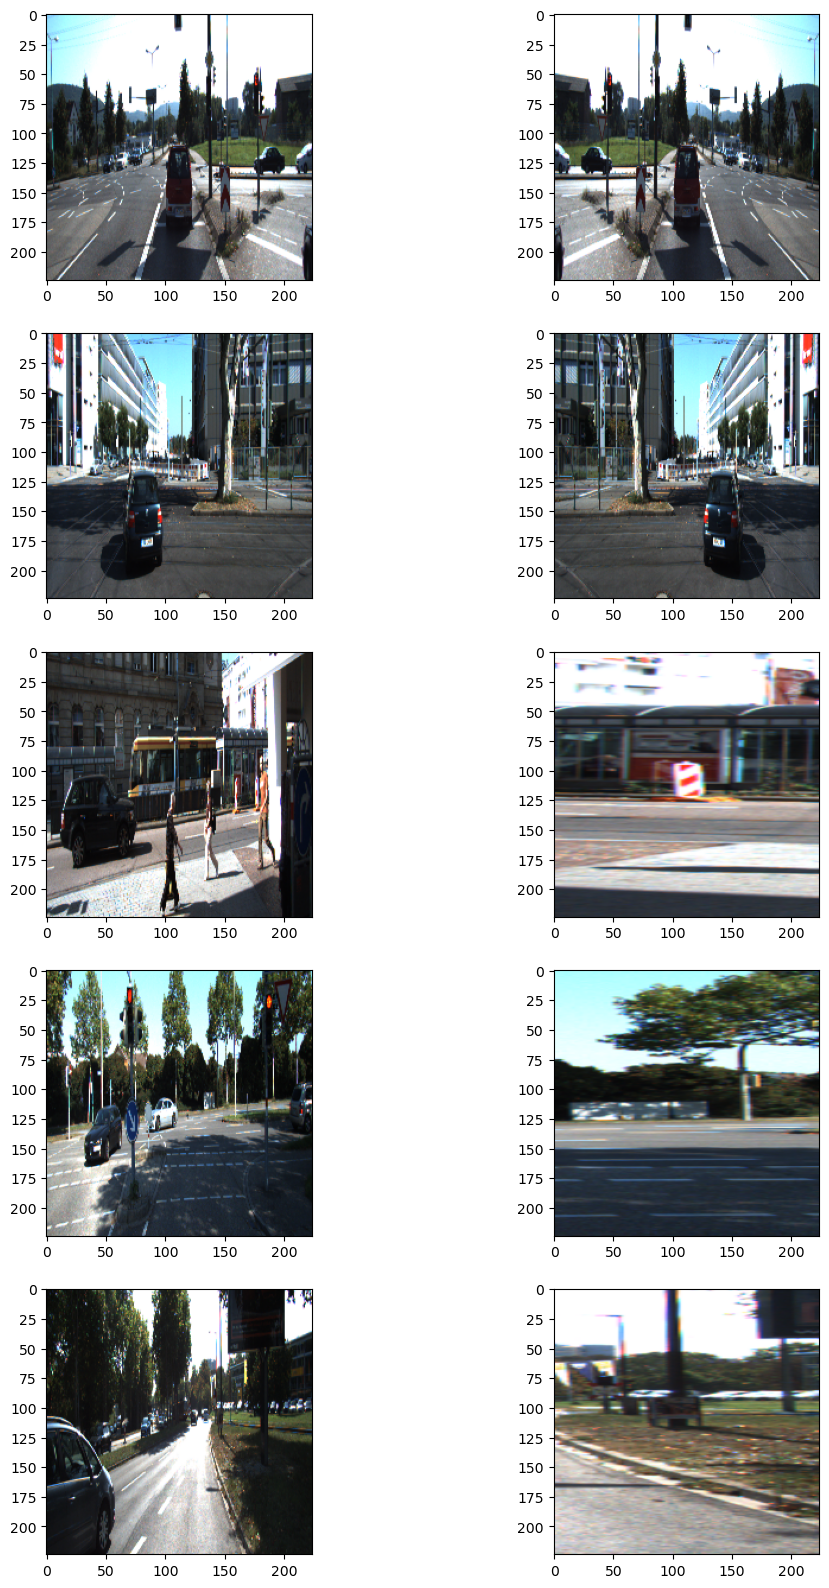

In [5]:
data_dir = os.path.join(os.getenv("HOME"), "work/semantic_segmentation/data/training")

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(data_dir, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [6]:
from torch.utils.data import Dataset

class KittiDataset(Dataset):
    '''
    KittiDataset은 PyTorch의 Dataset을 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Dataset을 커스텀하여 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Dataset이 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해 kitti dataset의 경로에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        input_images = sorted(glob(os.path.join(self.dir_path, "image_2", "*.png")))
        label_images = sorted(glob(os.path.join(self.dir_path, "semantic", "*.png")))

        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Dataset의 length로서 전체 dataset 크기를 반환합니다.
        return len(self.data)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        input_img_path, output_path = self.data[index]

        _input = imread(input_img_path)
        _output = imread(output_path)

        # 특정 라벨을 이진 마스크로 변환
        _output = (_output == 7).astype(np.uint8) * 1

        data = {
            "image": _input,
            "mask": _output,
        }

        if self.augmentation:
            augmented = self.augmentation(**data)
            _input = augmented["image"] / 255.0  # Normalize
            _output = augmented["mask"]

        # 📌 target 차원 확장 (H, W) → (1, H, W)
        _output = np.expand_dims(_output, axis=0)

        return (
            torch.tensor(_input, dtype=torch.float32).permute(2, 0, 1),  # (H, W, C) → (C, H, W)
            torch.tensor(_output, dtype=torch.float32)  # (1, H, W) 형식 유지
        )

    def shuffle_data(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습 중인 경우에 데이터를 random shuffle합니다.
        if self.is_train:
            np.random.shuffle(self.data)

In [7]:
from torch.utils.data import DataLoader

# Augmentation 설정
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_dataset = KittiDataset(
    data_dir,
    augmentation=augmentation,
    is_train=True
)

test_dataset = KittiDataset(
    data_dir,
    augmentation=test_preproc,
    is_train=False
)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/tmp/ipykernel_132/2497950994.py:7: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


모델 구조 만들기

In [8]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc1 = self.double_conv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        self.dropout = nn.Dropout(0.5)

        # Expanding Path (Decoder)
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec9 = self.double_conv(128, 64)

        # Output layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """2개의 Conv Layer로 이루어진 블록"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        c4 = self.enc4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.bottleneck(p4)
        c5 = self.dropout(c5)

        # Decoder
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.dec6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.dec7(u7)

        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.dec8(u8)

        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.dec9(u9)

        # Output
        output = torch.sigmoid(self.final(c9))
        return output

In [9]:
%%time

# 모델 저장 경로
model_path = "./work/semantic_segmentation/seg_model_unet.pth"

# 모델 생성
model = UNet(input_channels=3, output_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# 모델 저장
torch.save(model.state_dict(), model_path)

Epoch 1/100, Loss: 0.6601192355155945
Epoch 2/100, Loss: 0.6385162743655118
Epoch 3/100, Loss: 0.5645613263953816
Epoch 4/100, Loss: 0.5059756690805609
Epoch 5/100, Loss: 0.42545505545356055
Epoch 6/100, Loss: 0.3639149394902316
Epoch 7/100, Loss: 0.29334021562879736
Epoch 8/100, Loss: 0.29320905154401605
Epoch 9/100, Loss: 0.2691777470436963
Epoch 10/100, Loss: 0.26510466770692304
Epoch 11/100, Loss: 0.24206182902509515
Epoch 12/100, Loss: 0.27611426331780176
Epoch 13/100, Loss: 0.2523061700842597
Epoch 14/100, Loss: 0.25163337046449835
Epoch 15/100, Loss: 0.2346446229652925
Epoch 16/100, Loss: 0.20421396331353622
Epoch 17/100, Loss: 0.2163639705289494
Epoch 18/100, Loss: 0.20134495198726654
Epoch 19/100, Loss: 0.20196678286248987
Epoch 20/100, Loss: 0.1958457123149525
Epoch 21/100, Loss: 0.20745923708785663
Epoch 22/100, Loss: 0.19260737164454025
Epoch 23/100, Loss: 0.19070892171426254
Epoch 24/100, Loss: 0.19085517796603116
Epoch 25/100, Loss: 0.17453023926778274
Epoch 26/100, Loss:

RuntimeError: Parent directory ./work/semantic_segmentation does not exist.

In [10]:
import os

# 1. 경로 설정 (위에서 쓴 경로와 똑같이)
model_path = "./work/semantic_segmentation/seg_model_unet.pth"

# 2. 폴더가 없으면 만들기 (이 부분이 빠져서 에러가 난 거예요)
# os.path.dirname(model_path) -> "./work/semantic_segmentation" 경로만 추출
# exist_ok=True -> 폴더가 이미 있어도 에러 내지 말고 넘어가라는 뜻
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# 3. 모델 저장 다시 시도
torch.save(model.state_dict(), model_path)

print(f"모델이 성공적으로 저장되었습니다: {model_path}")

모델이 성공적으로 저장되었습니다: ./work/semantic_segmentation/seg_model_unet.pth


4. 시맨틱 세그멘테이션 모델 시각화

In [11]:
model = UNet(input_channels=3, output_channels=1)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # 평가 모드로 전환

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [12]:
import matplotlib.pyplot as plt

def get_output(model, preproc, image_path, output_path):
    # 원본 이미지 로드
    origin_img = imread(image_path)
    data = {"image": origin_img}

    # 전처리 적용
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # 모델 추론 (inference)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # 시그모이드 활성화 후 임계값(0.5) 적용하여 바이너리 마스크 생성
    output = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255   #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)

    # 배경과 결합하여 시각화 (Overlay)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, output, alpha=0.5)

    # 변환된 이미지 저장
    blended.save(output_path)

    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    # blended.show()
    return blended

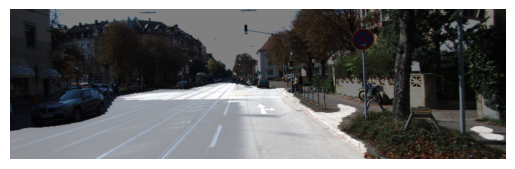

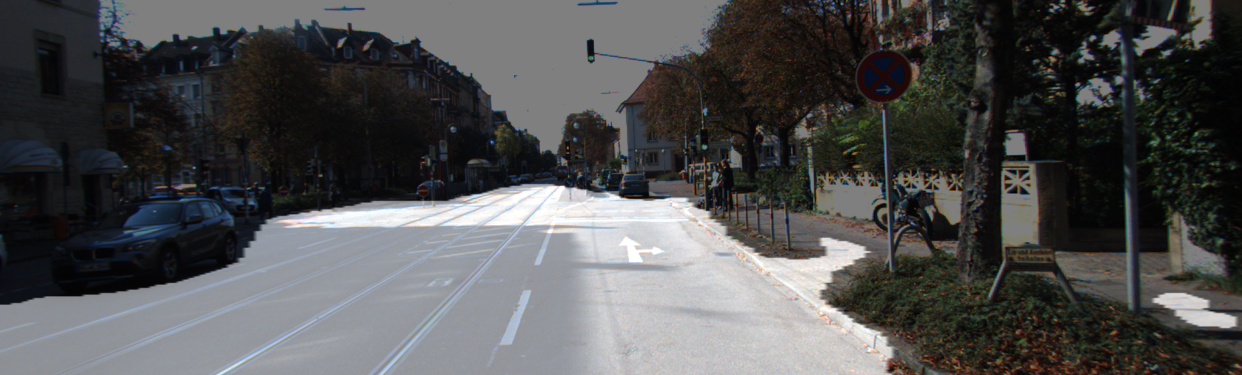

In [14]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
get_output(
     model,
     test_preproc,
     image_path=data_dir  + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=data_dir  + f'/result_{str(i).zfill(3)}.png'
 )

In [15]:
def calculate_iou_score(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant', preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    iou_score = intersection / (union + 1e-7)  # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    print(f"IoU : {iou_score:.6f}")
    return iou_score

In [16]:
def get_output(model, preproc, image_path, output_path, label_path=None):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    prediction = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255
    prediction = Image.fromarray(prediction).convert('L')

    background = Image.fromarray(origin_img).convert('RGBA')
    prediction_resized = prediction.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, prediction_resized, alpha=0.5)

    blended.save(output_path)
    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    target = None
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)["image"]
        target = (label_processed == 7).astype(np.uint8) * 1

    return blended, np.array(prediction), target

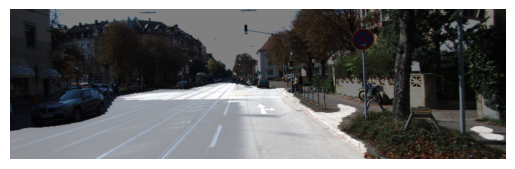

IoU : 0.894303


np.float64(0.8943030126129236)

In [18]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
     model,
     test_preproc,
     image_path=data_dir + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=data_dir + f'/result_{str(i).zfill(3)}.png',
     label_path=data_dir + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

5. 프로젝트 : 개선된 U-Net 모델 만들기

In [19]:
import torch
import numpy as np
import PIL
import skimage
import albumentations

print(torch.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.7.1+cu118
2.2.6
11.2.1
0.25.2
2.0.8


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 기존 코드의 DoubleConv와 유사하지만, 구조적 통일성을 위해 다시 정의합니다.
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [24]:
class NestedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, deep_supervision=False):
        super(NestedUNet, self).__init__()

        nb_filter = [32, 64, 128, 256, 512]
        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # ---------------------------------------------------
        # Level 0 (최상단)
        # ---------------------------------------------------
        self.conv0_0 = DoubleConv(in_channels, nb_filter[0])
        # [수정됨] 입력 채널 = 내 층(32) + 아래 층(64) = 96
        self.conv0_1 = DoubleConv(nb_filter[0] + nb_filter[1], nb_filter[0])
        # [수정됨] 입력 채널 = 내 층(32)*2 + 아래 층(64) = 128
        self.conv0_2 = DoubleConv(nb_filter[0]*2 + nb_filter[1], nb_filter[0])
        # [수정됨] 입력 채널 = 내 층(32)*3 + 아래 층(64) = 160
        self.conv0_3 = DoubleConv(nb_filter[0]*3 + nb_filter[1], nb_filter[0])
        # [수정됨] 입력 채널 = 내 층(32)*4 + 아래 층(64) = 192
        self.conv0_4 = DoubleConv(nb_filter[0]*4 + nb_filter[1], nb_filter[0])

        # ---------------------------------------------------
        # Level 1
        # ---------------------------------------------------
        self.conv1_0 = DoubleConv(nb_filter[0], nb_filter[1])
        # [수정됨] 입력 채널 = 내 층(64) + 아래 층(128) = 192
        self.conv1_1 = DoubleConv(nb_filter[1] + nb_filter[2], nb_filter[1])
        self.conv1_2 = DoubleConv(nb_filter[1]*2 + nb_filter[2], nb_filter[1])
        self.conv1_3 = DoubleConv(nb_filter[1]*3 + nb_filter[2], nb_filter[1])

        # ---------------------------------------------------
        # Level 2
        # ---------------------------------------------------
        self.conv2_0 = DoubleConv(nb_filter[1], nb_filter[2])
        # [수정됨] 입력 채널 = 내 층(128) + 아래 층(256) = 384
        self.conv2_1 = DoubleConv(nb_filter[2] + nb_filter[3], nb_filter[2])
        self.conv2_2 = DoubleConv(nb_filter[2]*2 + nb_filter[3], nb_filter[2])

        # ---------------------------------------------------
        # Level 3
        # ---------------------------------------------------
        self.conv3_0 = DoubleConv(nb_filter[2], nb_filter[3])
        # [수정됨] 입력 채널 = 내 층(256) + 아래 층(512) = 768
        self.conv3_1 = DoubleConv(nb_filter[3] + nb_filter[4], nb_filter[3])

        # ---------------------------------------------------
        # Level 4 (Bottleneck)
        # ---------------------------------------------------
        self.conv4_0 = DoubleConv(nb_filter[3], nb_filter[4])

        # Output Layer
        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Level 0
        x0_0 = self.conv0_0(x)
        
        # Level 1
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        
        # Level 2
        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        
        # Level 3
        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        
        # Level 4
        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            output = self.final(x0_4)
            return output

In [22]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCEDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs: 모델 출력 (Sigmoid 적용 전일 수도 있으므로 확인 필요, 보통 BCEWithLogitsLoss 사용 시에는 적용 전값)
        # 여기서는 사용자가 Sigmoid를 모델 마지막에 안 넣었으므로, BCEWithLogitsLoss와 유사하게 처리하거나
        # 아래 수식에서 Sigmoid를 적용해줍니다.
        
        inputs = torch.sigmoid(inputs) # 확률값으로 변환
        
        # Flatten (배치, 채널, H, W -> 1차원 벡터)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Dice Loss 계산
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        # BCE Loss 계산
        bce = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        # 최종 결합 (BCE + (1 - Dice))
        return bce + (1 - dice)

In [28]:
# 1. 모델 교체
# 모델 다시 생성 (중요!)
model = NestedUNet(in_channels=3, out_channels=1, deep_supervision=False)
model.to(device)

# 2. Loss 함수 교체
criterion = BCEDiceLoss()

# 3. 옵티마이저 (기존 유지)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 4. 데이터로더 (배치 사이즈 조절 필수!)
# U-Net++는 무거우므로 배치 사이즈를 16 -> 8 또는 4로 줄이는 것을 추천합니다.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) # 16에서 줄임
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 5. 학습 루프 (기존 코드 그대로 사용하되, Deep Supervision 사용 시 output 처리가 달라짐)
# 여기서는 deep_supervision=False로 했으므로 기존 루프 그대로 사용 가능합니다.
num_epochs = 50 # 테스트를 위해 적절히 설정

print("Start Training U-Net++...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Loss 계산 (타겟 float 변환)
        loss = criterion(outputs, targets.float())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# 모델 저장
torch.save(model.state_dict(), "./work/semantic_segmentation/seg_model_unetplusplus.pth")
print("U-Net++ Saved!")

Start Training U-Net++...
Epoch 1/50, Loss: 1.0812
Epoch 2/50, Loss: 0.8394
Epoch 3/50, Loss: 0.8760
Epoch 4/50, Loss: 0.7954
Epoch 5/50, Loss: 0.7748
Epoch 6/50, Loss: 0.7565
Epoch 7/50, Loss: 0.8206
Epoch 8/50, Loss: 0.7828
Epoch 9/50, Loss: 0.7798
Epoch 10/50, Loss: 0.7446
Epoch 11/50, Loss: 0.7499
Epoch 12/50, Loss: 0.7157
Epoch 13/50, Loss: 0.7089
Epoch 14/50, Loss: 0.7376
Epoch 15/50, Loss: 0.7062
Epoch 16/50, Loss: 0.6612
Epoch 17/50, Loss: 0.6663
Epoch 18/50, Loss: 0.6530
Epoch 19/50, Loss: 0.6954
Epoch 20/50, Loss: 0.6334
Epoch 21/50, Loss: 0.6016
Epoch 22/50, Loss: 0.6198
Epoch 23/50, Loss: 0.6382
Epoch 24/50, Loss: 0.6287
Epoch 25/50, Loss: 0.6067
Epoch 26/50, Loss: 0.5956
Epoch 27/50, Loss: 0.5738
Epoch 28/50, Loss: 0.5952
Epoch 29/50, Loss: 0.5623
Epoch 30/50, Loss: 0.5444
Epoch 31/50, Loss: 0.5247
Epoch 32/50, Loss: 0.5385
Epoch 33/50, Loss: 0.5226
Epoch 34/50, Loss: 0.5545
Epoch 35/50, Loss: 0.5510
Epoch 36/50, Loss: 0.5511
Epoch 37/50, Loss: 0.5092
Epoch 38/50, Loss: 0.

In [29]:
def calculate_iou(pred, target, threshold=0.5):
    # 모델의 출력값(확률)을 0과 1로 변환
    pred = (pred > threshold).float()
    target = target.float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    if union == 0:
        return 1.0 # 둘 다 공백인 경우 정확도 1
    else:
        return intersection / union

Step 2. 두 모델 불러오기 (U-Net vs U-Net++)

In [30]:
# 1. 모델 초기화
model_unet = UNet(input_channels=3, output_channels=1).to(device)
model_unetplus = NestedUNet(in_channels=3, out_channels=1, deep_supervision=False).to(device)

# 2. 저장된 가중치 불러오기 (경로를 확인해주세요)
unet_path = "./work/semantic_segmentation/seg_model_unet.pth"
unetplus_path = "./work/semantic_segmentation/seg_model_unetplusplus.pth"

# 파일이 있다면 로드 (없으면 에러 처리)
if os.path.exists(unet_path):
    model_unet.load_state_dict(torch.load(unet_path))
    print("U-Net Loaded!")
else:
    print("U-Net weight file not found.")

if os.path.exists(unetplus_path):
    model_unetplus.load_state_dict(torch.load(unetplus_path))
    print("U-Net++ Loaded!")
else:
    print("U-Net++ weight file not found.")

# 평가 모드로 전환
model_unet.eval()
model_unetplus.eval()

U-Net Loaded!
U-Net++ Loaded!


NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv0_1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

Step 3. 시각화 및 비교 (Result Visualization)

Visualizing Comparison...


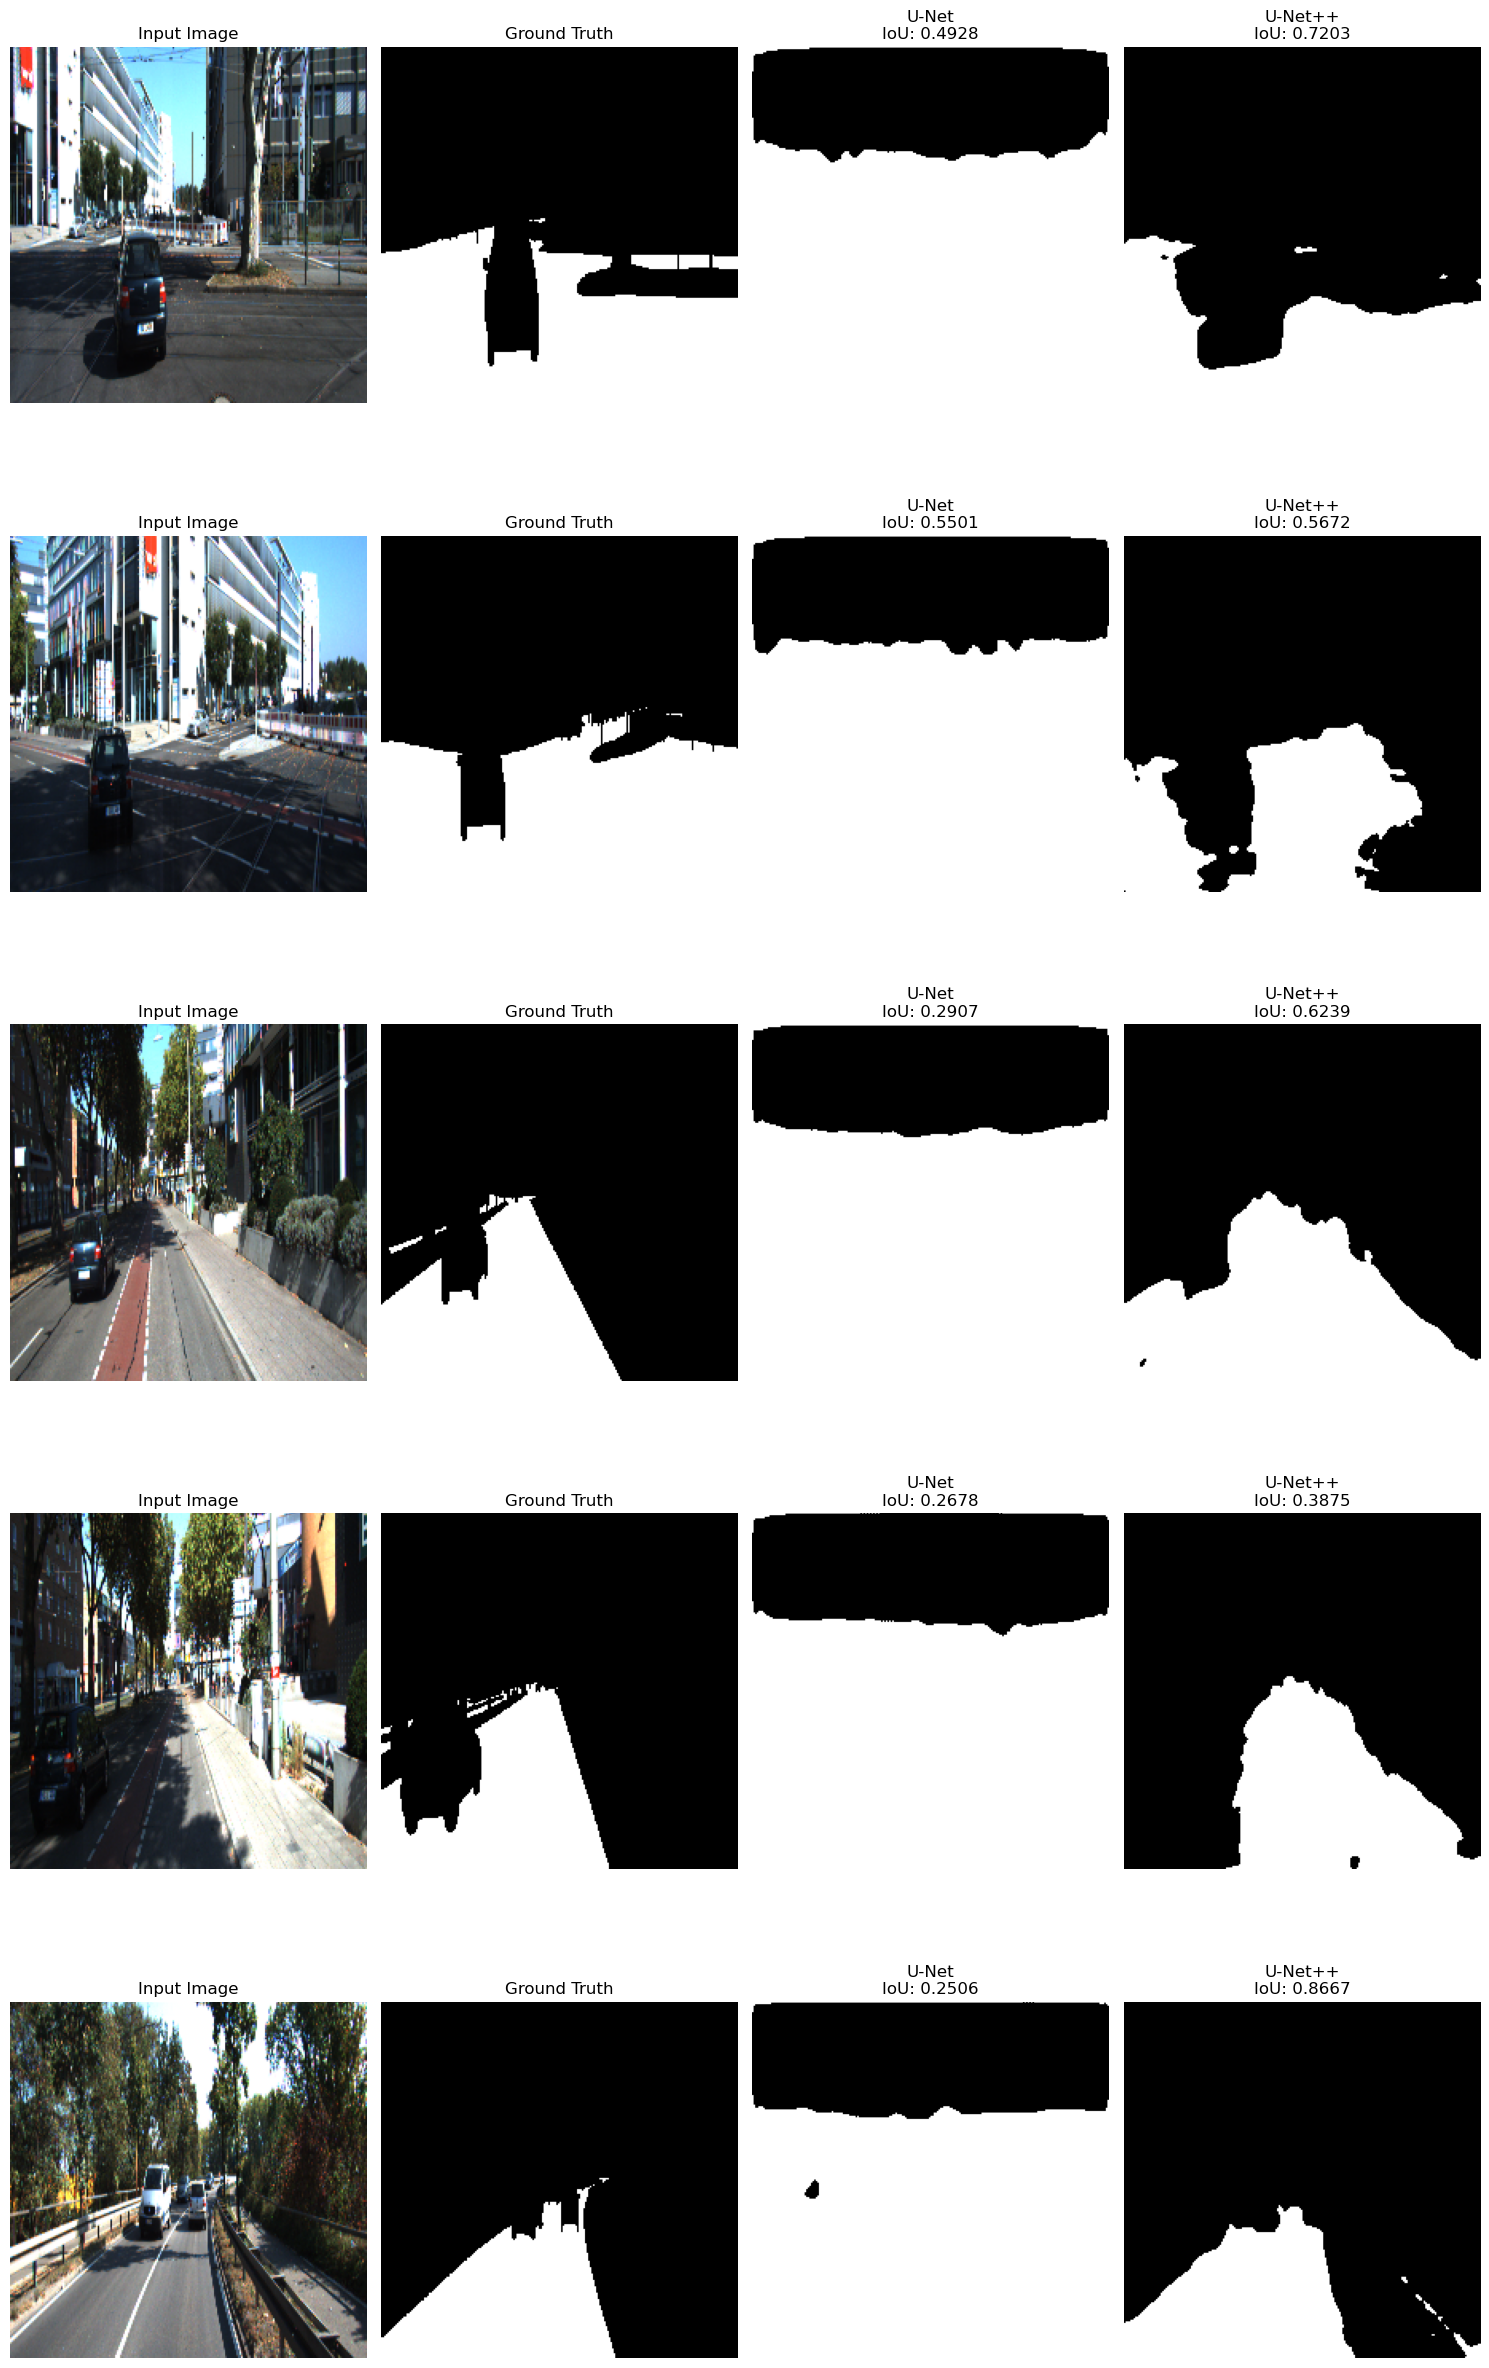

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_comparison(loader, model1, model2, device, num_samples=3):
    # 데이터 로더에서 배치 하나 가져오기
    inputs, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    # 추론 (Inference)
    with torch.no_grad():
        outputs1 = model1(inputs) # U-Net
        outputs2 = model2(inputs) # U-Net++

        # Sigmoid 적용 (0~1 사이 값으로 변환)
        preds1 = torch.sigmoid(outputs1)
        preds2 = torch.sigmoid(outputs2)

    # 시각화
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        img = inputs[i].cpu().permute(1, 2, 0).numpy() # (C,H,W) -> (H,W,C)
        mask = targets[i].cpu().squeeze().numpy()
        p1 = preds1[i].cpu().squeeze().numpy()
        p2 = preds2[i].cpu().squeeze().numpy()

        # IoU 계산 (개별 이미지에 대해)
        iou1 = calculate_iou(preds1[i], targets[i]).item()
        iou2 = calculate_iou(preds2[i], targets[i]).item()

        # 1. 원본 이미지
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')

        # 2. 정답 마스크 (Ground Truth)
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # 3. U-Net 예측
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(p1 > 0.5, cmap='gray') # Threshold 0.5 적용
        plt.title(f"U-Net\nIoU: {iou1:.4f}")
        plt.axis('off')

        # 4. U-Net++ 예측
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(p2 > 0.5, cmap='gray')
        plt.title(f"U-Net++\nIoU: {iou2:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 실행! (테스트 로더 사용)
print("Visualizing Comparison...")
visualize_comparison(test_loader, model_unet, model_unetplus, device, num_samples=5)

In [51]:
import torch.nn.functional as F

def get_boundary(mask, dilation_ratio=0.02):
    """
    마스크의 경계선(Boundary)을 추출하는 함수
    mask: (B, C, H, W) 형태의 텐서
    """
    # 1. 커널 사이즈 계산 (이미지 크기에 비례하여 테두리 두께 결정)
    _, _, h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    
    if dilation < 1:
        dilation = 1

    # 2. MaxPool2d를 이용한 팽창(Dilation) 연산 -> 테두리를 두껍게 만듦
    # padding을 kernel_size // 2로 설정하여 크기 유지
    dilated_mask = F.max_pool2d(mask, kernel_size=2*dilation+1, stride=1, padding=dilation)
    
    # 3. 경계선 추출: (팽창된 마스크) - (원본 마스크)
    # 팽창된 영역에서 원본을 빼면 테두리만 남습니다.
    boundary = dilated_mask - mask
    return boundary

# 기존 함수를 이 코드로 교체하세요
def calculate_boundary_iou_score(pred, target, threshold=0.5):
    # 0과 1로 변환
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    # 차원 맞추기 (무조건 4차원 [Batch, Channel, H, W] 형태로 만듦)
    
    # 1. 만약 (Channel, H, W) 3차원이라면 -> (1, Channel, H, W)로 변경
    if pred_binary.dim() == 3:
        pred_binary = pred_binary.unsqueeze(0)
    if target_binary.dim() == 3:
        target_binary = target_binary.unsqueeze(0)
        
    # 2. 만약 (H, W) 2차원이라면 -> (1, 1, H, W)로 변경
    if pred_binary.dim() == 2:
        pred_binary = pred_binary.unsqueeze(0).unsqueeze(0)
    if target_binary.dim() == 2:
        target_binary = target_binary.unsqueeze(0).unsqueeze(0)

    # 경계선 추출
    pred_bound = get_boundary(pred_binary)
    target_bound = get_boundary(target_binary)
    
    # IoU 계산
    intersection = (pred_bound * target_bound).sum()
    union = pred_bound.sum() + target_bound.sum() - intersection
    if union == 0: return 1.0
    return (intersection / union).item()

Visualizing with Boundary IoU...


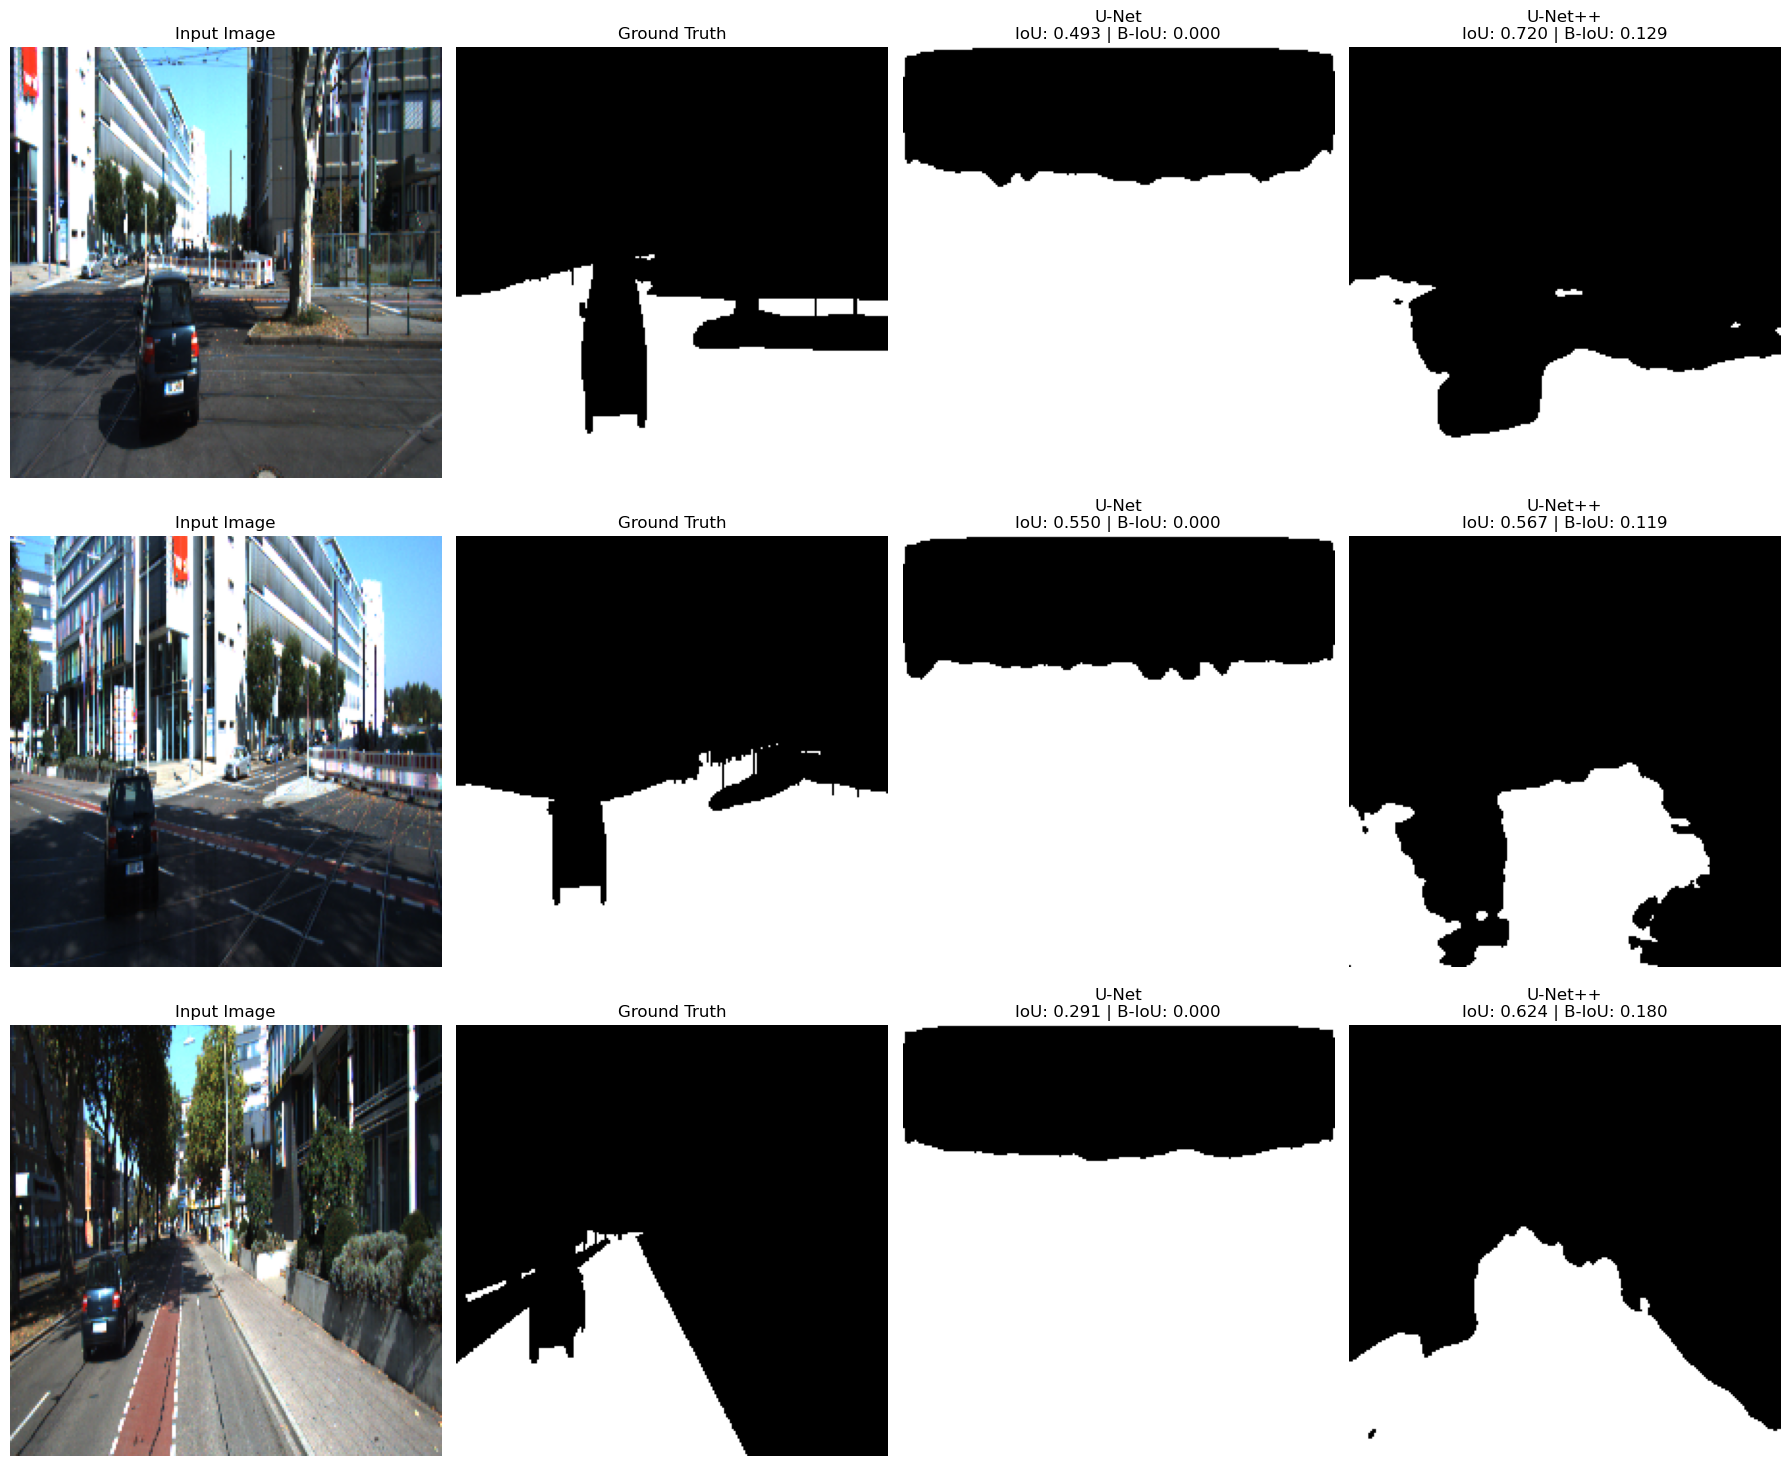

In [52]:
def visualize_comparison_with_boundary(loader, model1, model2, device, num_samples=3):
    # 데이터 로더에서 배치 하나 가져오기
    inputs, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    # 추론 (Inference)
    with torch.no_grad():
        outputs1 = model1(inputs) # U-Net
        outputs2 = model2(inputs) # U-Net++

        preds1 = torch.sigmoid(outputs1)
        preds2 = torch.sigmoid(outputs2)

    # 시각화
    plt.figure(figsize=(18, 5 * num_samples)) # 가로 길이 조금 늘림

    for i in range(num_samples):
        img = inputs[i].cpu().permute(1, 2, 0).numpy()
        mask = targets[i].cpu().squeeze().numpy()
        p1 = preds1[i].cpu().squeeze().numpy()
        p2 = preds2[i].cpu().squeeze().numpy()

        # 1. Standard IoU (전체 면적)
        std_iou1 = calculate_iou(preds1[i], targets[i])
        std_iou2 = calculate_iou(preds2[i], targets[i])
        
        # 2. Boundary IoU (테두리 정교함) -> 여기서 적용!
        bound_iou1 = calculate_boundary_iou(preds1[i], targets[i])
        bound_iou2 = calculate_boundary_iou(preds2[i], targets[i])

        # 이미지 출력
        # 1. 원본
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')

        # 2. 정답
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # 3. U-Net 결과
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(p1 > 0.5, cmap='gray')
        plt.title(f"U-Net\nIoU: {std_iou1:.3f} | B-IoU: {bound_iou1:.3f}") # 점수 2개 표시
        plt.axis('off')

        # 4. U-Net++ 결과
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(p2 > 0.5, cmap='gray')
        plt.title(f"U-Net++\nIoU: {std_iou2:.3f} | B-IoU: {bound_iou2:.3f}") # 점수 2개 표시
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 실행
print("Visualizing with Boundary IoU...")
# model_unet, model_unetplus가 메모리에 로드되어 있어야 합니다.
visualize_comparison_with_boundary(test_loader, model_unet, model_unetplus, device, num_samples=3)

한눈에평가

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# U-Net++의 핵심 블록
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# U-Net++ (Nested U-Net) 아키텍처
class NestedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, deep_supervision=False):
        super(NestedUNet, self).__init__()
        nb_filter = [32, 64, 128, 256, 512]
        self.deep_supervision = deep_supervision
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # L0
        self.conv0_0 = DoubleConv(in_channels, nb_filter[0])
        self.conv0_1 = DoubleConv(nb_filter[0] + nb_filter[1], nb_filter[0])
        self.conv0_2 = DoubleConv(nb_filter[0]*2 + nb_filter[1], nb_filter[0])
        self.conv0_3 = DoubleConv(nb_filter[0]*3 + nb_filter[1], nb_filter[0])
        self.conv0_4 = DoubleConv(nb_filter[0]*4 + nb_filter[1], nb_filter[0])
        # L1
        self.conv1_0 = DoubleConv(nb_filter[0], nb_filter[1])
        self.conv1_1 = DoubleConv(nb_filter[1] + nb_filter[2], nb_filter[1])
        self.conv1_2 = DoubleConv(nb_filter[1]*2 + nb_filter[2], nb_filter[1])
        self.conv1_3 = DoubleConv(nb_filter[1]*3 + nb_filter[2], nb_filter[1])
        # L2
        self.conv2_0 = DoubleConv(nb_filter[1], nb_filter[2])
        self.conv2_1 = DoubleConv(nb_filter[2] + nb_filter[3], nb_filter[2])
        self.conv2_2 = DoubleConv(nb_filter[2]*2 + nb_filter[3], nb_filter[2])
        # L3
        self.conv3_0 = DoubleConv(nb_filter[2], nb_filter[3])
        self.conv3_1 = DoubleConv(nb_filter[3] + nb_filter[4], nb_filter[3])
        # L4
        self.conv4_0 = DoubleConv(nb_filter[3], nb_filter[4])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        
        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        
        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        
        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            return self.final(x0_4)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

# ==========================================
# 1. 평가 지표 함수 (IoU & Boundary IoU)
# ==========================================
def calculate_iou_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    if union == 0: return 1.0
    return (intersection / union).item()

def get_boundary(mask, dilation_ratio=0.02):
    _, _, h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    if dilation < 1: dilation = 1
    dilated_mask = F.max_pool2d(mask, kernel_size=2*dilation+1, stride=1, padding=dilation)
    return dilated_mask - mask

def calculate_boundary_iou_score(pred, target, threshold=0.5):
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    if len(pred_binary.shape) == 2: pred_binary = pred_binary.unsqueeze(0).unsqueeze(0)
    if len(target_binary.shape) == 2: target_binary = target_binary.unsqueeze(0).unsqueeze(0)
    if len(target_binary.shape) == 3: target_binary = target_binary.unsqueeze(1)

    pred_bound = get_boundary(pred_binary)
    target_bound = get_boundary(target_binary)
    
    intersection = (pred_bound * target_bound).sum()
    union = pred_bound.sum() + target_bound.sum() - intersection
    if union == 0: return 1.0
    return (intersection / union).item()

# ==========================================
# 2. 통합 학습 함수 (Trainer)
# ==========================================
def train_model(model_name, model, train_loader, epochs, device):
    print(f"\n🚀 Start Training {model_name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss() # Sigmoid 포함된 Loss
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() == 3: targets = targets.unsqueeze(1) # (B, H, W) -> (B, 1, H, W)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Deep Supervision 처리 (List인 경우 마지막 Output만 사용)
            if isinstance(outputs, list): outputs = outputs[-1]
            
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            
        print(f"[{model_name}] Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")
    return model

# ==========================================
# 3. 최종 비교 및 시각화 함수 (Reporter)
# ==========================================
def compare_models(unet, unetpp, test_loader, device):
    unet.eval()
    unetpp.eval()
    
    scores = {'unet_iou': [], 'unet_biou': [], 'pp_iou': [], 'pp_biou': []}
    
    # 1. 전체 데이터셋 정량 평가
    print("\n📊 Evaluating Models on Test Set...")
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() == 3: targets = targets.unsqueeze(1)
            
            # Inference
            out_unet = torch.sigmoid(unet(inputs))
            out_pp = torch.sigmoid(unetpp(inputs))
            
            # Batch 내 개별 계산
            for i in range(inputs.size(0)):
                scores['unet_iou'].append(calculate_iou_score(out_unet[i], targets[i]))
                scores['unet_biou'].append(calculate_boundary_iou_score(out_unet[i], targets[i]))
                scores['pp_iou'].append(calculate_iou_score(out_pp[i], targets[i]))
                scores['pp_biou'].append(calculate_boundary_iou_score(out_pp[i], targets[i]))

    # 평균 점수 출력
    print(f"\n🏆 Final Score Report")
    print(f"U-Net   | Mean IoU: {np.mean(scores['unet_iou']):.4f} | Mean Boundary IoU: {np.mean(scores['unet_biou']):.4f}")
    print(f"U-Net++ | Mean IoU: {np.mean(scores['pp_iou']):.4f} | Mean Boundary IoU: {np.mean(scores['pp_biou']):.4f}")

    # 2. 정성 평가 (시각화) - 랜덤 3장
    print("\n🎨 Visualizing Results...")
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    if targets.dim() == 3: targets = targets.unsqueeze(1)
    
    with torch.no_grad():
        out_u = torch.sigmoid(unet(inputs))
        out_pp = torch.sigmoid(unetpp(inputs))
    
    plt.figure(figsize=(15, 10))
    for i in range(min(3, inputs.size(0))):
        # Input
        plt.subplot(3, 4, i*4 + 1)
        img = inputs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Input")
        plt.axis('off')
        
        # GT
        plt.subplot(3, 4, i*4 + 2)
        plt.imshow(targets[i].cpu().squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        # U-Net
        plt.subplot(3, 4, i*4 + 3)
        plt.imshow(out_u[i].cpu().squeeze() > 0.5, cmap='gray')
        plt.title(f"U-Net\nIoU: {scores['unet_iou'][i]:.2f}")
        plt.axis('off')
        
        # U-Net++
        plt.subplot(3, 4, i*4 + 4)
        plt.imshow(out_pp[i].cpu().squeeze() > 0.5, cmap='gray')
        plt.title(f"U-Net++\nIoU: {scores['pp_iou'][i]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. 메인 실행 블록 (Run Everything)
# ==========================================
if __name__ == "__main__":
    # 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 8  # U-Net++ 메모리 고려하여 8 권장
    EPOCHS = 5      # 시간 관계상 5 (충분한 학습을 위해선 20~50 권장)

    # 데이터 로더 준비
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 1. U-Net 학습
    model_u = UNet(input_channels=3, output_channels=1).to(device)
    model_u = train_model("U-Net", model_u, train_loader, EPOCHS, device)

    # 2. U-Net++ 학습
    model_pp = NestedUNet(in_channels=3, out_channels=1).to(device)
    model_pp = train_model("U-Net++", model_pp, train_loader, EPOCHS, device)

    # 3. 최종 비교 (모든 목표 달성 확인)
    compare_models(model_u, model_pp, test_loader, device)


🚀 Start Training U-Net...


[U-Net] Epoch 1 Loss: 0.8619


[U-Net] Epoch 2 Loss: 0.7160


[U-Net] Epoch 3 Loss: 0.6931


[U-Net] Epoch 4 Loss: 0.6931


[U-Net] Epoch 5 Loss: 0.6931

🚀 Start Training U-Net++...


[U-Net++] Epoch 1 Loss: 0.5322


[U-Net++] Epoch 2 Loss: 0.4319


[U-Net++] Epoch 3 Loss: 0.3973


[U-Net++] Epoch 4 Loss: 0.4006


[U-Net++] Epoch 5 Loss: 0.3877

📊 Evaluating Models on Test Set...


  0%|          | 0/4 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 4, got 3)

In [55]:
import numpy as np
import torch
import torch.nn.functional as F

def get_boundary(mask, dilation_ratio=0.02):
    """
    마스크의 경계선(Boundary)을 추출하는 함수 (차원 에러 해결 버전)
    """
    # [수정 핵심] 무조건 4개를 푸는 게 아니라, 마지막 2개(H, W)만 가져옵니다.
    # 이렇게 하면 입력이 (C, H, W) 3차원이든 (B, C, H, W) 4차원이든 상관없이 작동합니다.
    h, w = mask.shape[-2:] 
    
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    
    if dilation < 1:
        dilation = 1

    # MaxPool2d는 3차원(C,H,W)이나 4차원(B,C,H,W) 모두 지원하므로 그대로 둡니다.
    dilated_mask = F.max_pool2d(mask, kernel_size=2*dilation+1, stride=1, padding=dilation)
    
    boundary = dilated_mask - mask
    return boundary

def calculate_boundary_iou_score(pred, target, threshold=0.5):
    """
    Boundary IoU 계산 함수 (차원 안전장치 포함)
    """
    # 0과 1로 변환
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    # 안전장치: 차원이 부족하면 늘려줍니다.
    # PyTorch 텐서의 차원(dim)을 확인하여 처리
    if pred_binary.dim() == 2:   # (H, W) -> (1, H, W)
        pred_binary = pred_binary.unsqueeze(0)
    if target_binary.dim() == 2: # (H, W) -> (1, H, W)
        target_binary = target_binary.unsqueeze(0)
        
    # get_boundary는 이제 3차원(C, H, W)도 잘 처리합니다.
    pred_bound = get_boundary(pred_binary)
    target_bound = get_boundary(target_binary)
    
    # IoU 계산
    intersection = (pred_bound * target_bound).sum()
    union = pred_bound.sum() + target_bound.sum() - intersection
    
    if union == 0:
        return 1.0 
    
    return (intersection / union).item()


🚀 Start Training U-Net...


[U-Net] Epoch 1 Loss: 0.8491


[U-Net] Epoch 2 Loss: 0.7161


[U-Net] Epoch 3 Loss: 0.6931


[U-Net] Epoch 4 Loss: 0.6931


[U-Net] Epoch 5 Loss: 0.6931

🚀 Start Training U-Net++...


[U-Net++] Epoch 1 Loss: 0.4224


[U-Net++] Epoch 2 Loss: 0.3447


[U-Net++] Epoch 3 Loss: 0.3081


[U-Net++] Epoch 4 Loss: 0.3160


[U-Net++] Epoch 5 Loss: 0.2929

📊 Evaluating Models on Test Set...


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]



🏆 Final Score Report
U-Net   | Mean IoU: 0.0000 | Mean Boundary IoU: 0.0000
U-Net++ | Mean IoU: 0.7135 | Mean Boundary IoU: 0.2911

🎨 Visualizing Results...


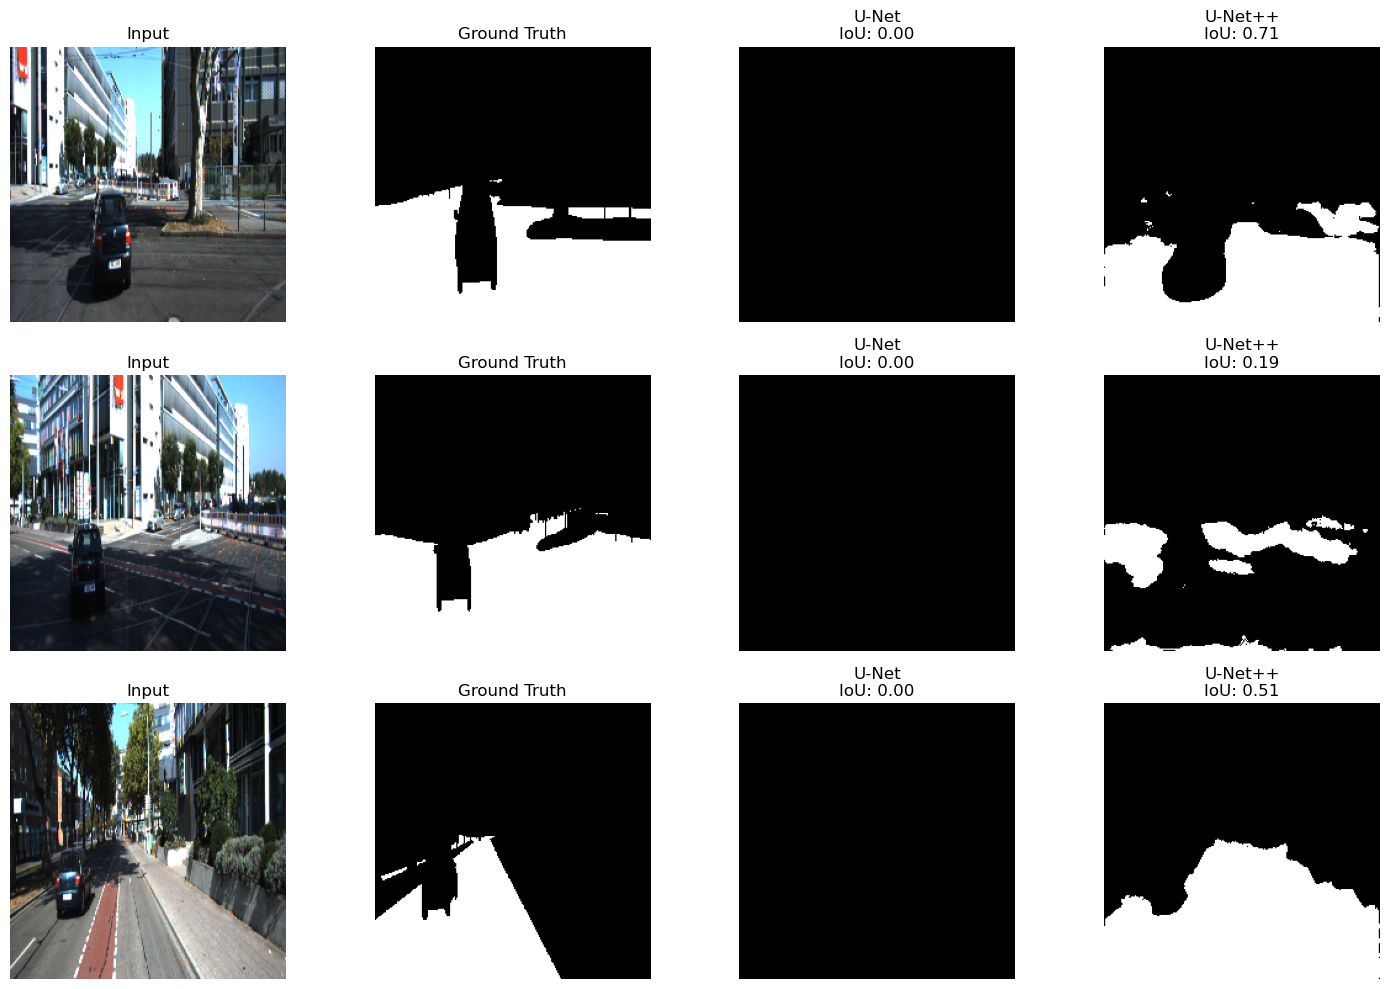

In [56]:
# ==========================================
# 3. 최종 비교 및 시각화 함수 (Reporter)
# ==========================================
def compare_models(unet, unetpp, test_loader, device):
    unet.eval()
    unetpp.eval()
    
    scores = {'unet_iou': [], 'unet_biou': [], 'pp_iou': [], 'pp_biou': []}
    
    # 1. 전체 데이터셋 정량 평가
    print("\n📊 Evaluating Models on Test Set...")
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() == 3: targets = targets.unsqueeze(1)
            
            # Inference
            out_unet = torch.sigmoid(unet(inputs))
            out_pp = torch.sigmoid(unetpp(inputs))
            
            # Batch 내 개별 계산
            for i in range(inputs.size(0)):
                scores['unet_iou'].append(calculate_iou_score(out_unet[i], targets[i]))
                scores['unet_biou'].append(calculate_boundary_iou_score(out_unet[i], targets[i]))
                scores['pp_iou'].append(calculate_iou_score(out_pp[i], targets[i]))
                scores['pp_biou'].append(calculate_boundary_iou_score(out_pp[i], targets[i]))

    # 평균 점수 출력
    print(f"\n🏆 Final Score Report")
    print(f"U-Net   | Mean IoU: {np.mean(scores['unet_iou']):.4f} | Mean Boundary IoU: {np.mean(scores['unet_biou']):.4f}")
    print(f"U-Net++ | Mean IoU: {np.mean(scores['pp_iou']):.4f} | Mean Boundary IoU: {np.mean(scores['pp_biou']):.4f}")

    # 2. 정성 평가 (시각화) - 랜덤 3장
    print("\n🎨 Visualizing Results...")
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    if targets.dim() == 3: targets = targets.unsqueeze(1)
    
    with torch.no_grad():
        out_u = torch.sigmoid(unet(inputs))
        out_pp = torch.sigmoid(unetpp(inputs))
    
    plt.figure(figsize=(15, 10))
    for i in range(min(3, inputs.size(0))):
        # Input
        plt.subplot(3, 4, i*4 + 1)
        img = inputs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Input")
        plt.axis('off')
        
        # GT
        plt.subplot(3, 4, i*4 + 2)
        plt.imshow(targets[i].cpu().squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        # U-Net
        plt.subplot(3, 4, i*4 + 3)
        plt.imshow(out_u[i].cpu().squeeze() > 0.5, cmap='gray')
        plt.title(f"U-Net\nIoU: {scores['unet_iou'][i]:.2f}")
        plt.axis('off')
        
        # U-Net++
        plt.subplot(3, 4, i*4 + 4)
        plt.imshow(out_pp[i].cpu().squeeze() > 0.5, cmap='gray')
        plt.title(f"U-Net++\nIoU: {scores['pp_iou'][i]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. 메인 실행 블록 (Run Everything)
# ==========================================
if __name__ == "__main__":
    # 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 8  # U-Net++ 메모리 고려하여 8 권장
    EPOCHS = 5      # 시간 관계상 5 (충분한 학습을 위해선 20~50 권장)

    # 데이터 로더 준비
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 1. U-Net 학습
    model_u = UNet(input_channels=3, output_channels=1).to(device)
    model_u = train_model("U-Net", model_u, train_loader, EPOCHS, device)

    # 2. U-Net++ 학습
    model_pp = NestedUNet(in_channels=3, out_channels=1).to(device)
    model_pp = train_model("U-Net++", model_pp, train_loader, EPOCHS, device)

    # 3. 최종 비교 (모든 목표 달성 확인)
    compare_models(model_u, model_pp, test_loader, device)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

# ==========================================
# 1. 평가 지표 함수 (IoU & Boundary IoU)
# ==========================================
def calculate_iou_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    if union == 0: return 1.0
    return (intersection / union).item()

def get_boundary(mask, dilation_ratio=0.02):
    _, _, h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    if dilation < 1: dilation = 1
    dilated_mask = F.max_pool2d(mask, kernel_size=2*dilation+1, stride=1, padding=dilation)
    return dilated_mask - mask

def calculate_boundary_iou_score(pred, target, threshold=0.5):
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    if len(pred_binary.shape) == 2: pred_binary = pred_binary.unsqueeze(0).unsqueeze(0)
    if len(target_binary.shape) == 2: target_binary = target_binary.unsqueeze(0).unsqueeze(0)
    if len(target_binary.shape) == 3: target_binary = target_binary.unsqueeze(1)

    pred_bound = get_boundary(pred_binary)
    target_bound = get_boundary(target_binary)
    
    intersection = (pred_bound * target_bound).sum()
    union = pred_bound.sum() + target_bound.sum() - intersection
    if union == 0: return 1.0
    return (intersection / union).item()

# ==========================================
# 2. 통합 학습 함수 (Trainer)
# ==========================================
def train_model(model_name, model, train_loader, epochs, device):
    print(f"\n🚀 Start Training {model_name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss() # Sigmoid 포함된 Loss
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() == 3: targets = targets.unsqueeze(1) # (B, H, W) -> (B, 1, H, W)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Deep Supervision 처리 (List인 경우 마지막 Output만 사용)
            if isinstance(outputs, list): outputs = outputs[-1]
            
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            
        print(f"[{model_name}] Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")
    return model

# ==========================================
# 3. 최종 비교 및 시각화 함수 (Reporter)
# ==========================================
def compare_models(unet, unetpp, test_loader, device):
    unet.eval()
    unetpp.eval()
    
    scores = {'unet_iou': [], 'unet_biou': [], 'pp_iou': [], 'pp_biou': []}
    
    # 1. 전체 데이터셋 정량 평가
    print("\n📊 Evaluating Models on Test Set...")
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() == 3: targets = targets.unsqueeze(1)
            
            # Inference
            out_unet = torch.sigmoid(unet(inputs))
            out_pp = torch.sigmoid(unetpp(inputs))
            
            # Batch 내 개별 계산
            for i in range(inputs.size(0)):
                scores['unet_iou'].append(calculate_iou_score(out_unet[i], targets[i]))
                scores['unet_biou'].append(calculate_boundary_iou_score(out_unet[i], targets[i]))
                scores['pp_iou'].append(calculate_iou_score(out_pp[i], targets[i]))
                scores['pp_biou'].append(calculate_boundary_iou_score(out_pp[i], targets[i]))

    # 평균 점수 출력
    print(f"\n🏆 Final Score Report")
    print(f"U-Net   | Mean IoU: {np.mean(scores['unet_iou']):.4f} | Mean Boundary IoU: {np.mean(scores['unet_biou']):.4f}")
    print(f"U-Net++ | Mean IoU: {np.mean(scores['pp_iou']):.4f} | Mean Boundary IoU: {np.mean(scores['pp_biou']):.4f}")

    # 2. 정성 평가 (시각화) - 랜덤 3장
    print("\n🎨 Visualizing Results...")
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    if targets.dim() == 3: targets = targets.unsqueeze(1)
    
    with torch.no_grad():
        out_u = torch.sigmoid(unet(inputs))
        out_pp = torch.sigmoid(unetpp(inputs))
    
    plt.figure(figsize=(15, 10))
    for i in range(min(3, inputs.size(0))):
        # Input
        plt.subplot(3, 4, i*4 + 1)
        img = inputs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Input")
        plt.axis('off')
        
        # GT
        plt.subplot(3, 4, i*4 + 2)
        plt.imshow(targets[i].cpu().squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        # U-Net
        plt.subplot(3, 4, i*4 + 3)
        plt.imshow(out_u[i].cpu().squeeze() > 0.5, cmap='gray')
        plt.title(f"U-Net\nIoU: {scores['unet_iou'][i]:.2f}")
        plt.axis('off')
        
        # U-Net++
        plt.subplot(3, 4, i*4 + 4)
        plt.imshow(out_pp[i].cpu().squeeze() > 0.5, cmap='gray')
        plt.title(f"U-Net++\nIoU: {scores['pp_iou'][i]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. 메인 실행 블록 (Run Everything)
# ==========================================
if __name__ == "__main__":
    # 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 8  # U-Net++ 메모리 고려하여 8 권장
    EPOCHS = 50     # 시간 관계상 5 (충분한 학습을 위해선 20~50 권장)

    # 데이터 로더 준비
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 1. U-Net 학습
    model_u = UNet(input_channels=3, output_channels=1).to(device)
    model_u = train_model("U-Net", model_u, train_loader, EPOCHS, device)

    # 2. U-Net++ 학습
    model_pp = NestedUNet(in_channels=3, out_channels=1).to(device)
    model_pp = train_model("U-Net++", model_pp, train_loader, EPOCHS, device)

    # 3. 최종 비교 (모든 목표 달성 확인)
    compare_models(model_u, model_pp, test_loader, device)


🚀 Start Training U-Net...


[U-Net] Epoch 1 Loss: 0.8589


[U-Net] Epoch 2 Loss: 0.7132


[U-Net] Epoch 3 Loss: 0.6931


[U-Net] Epoch 4 Loss: 0.6931


[U-Net] Epoch 5 Loss: 0.6931


[U-Net] Epoch 6 Loss: 0.6931


[U-Net] Epoch 7 Loss: 0.6931


[U-Net] Epoch 8 Loss: 0.6931


[U-Net] Epoch 9 Loss: 0.6931


[U-Net] Epoch 10 Loss: 0.6931


[U-Net] Epoch 11 Loss: 0.6931


[U-Net] Epoch 12 Loss: 0.6931


[U-Net] Epoch 13 Loss: 0.6931


[U-Net] Epoch 14 Loss: 0.6931


[U-Net] Epoch 15 Loss: 0.6931


[U-Net] Epoch 16 Loss: 0.6931


[U-Net] Epoch 17 Loss: 0.6931


[U-Net] Epoch 18 Loss: 0.6931


[U-Net] Epoch 19 Loss: 0.6931


[U-Net] Epoch 20 Loss: 0.6931


[U-Net] Epoch 21 Loss: 0.6931


[U-Net] Epoch 22 Loss: 0.6931


[U-Net] Epoch 23 Loss: 0.6931


[U-Net] Epoch 24 Loss: 0.6931


[U-Net] Epoch 25 Loss: 0.6931


[U-Net] Epoch 26 Loss: 0.6931


[U-Net] Epoch 27 Loss: 0.6931


[U-Net] Epoch 28 Loss: 0.6931


[U-Net] Epoch 29 Loss: 0.6931


[U-Net] Epoch 30 Loss: 0.6931


[U-Net] Epoch 31 Loss: 0.6931


[U-Net] Epoch 32 Loss: 0.6931


[U-Net] Epoch 33 Loss: 0.6931


[U-Net] Epoch 34 Loss: 0.6931


[U-Net] Epoch 35 Loss: 0.6931


[U-Net] Epoch 36 Loss: 0.6931


[U-Net] Epoch 37 Loss: 0.6931


[U-Net] Epoch 38 Loss: 0.6931


[U-Net] Epoch 39 Loss: 0.6931


[U-Net] Epoch 40 Loss: 0.6931


[U-Net] Epoch 41 Loss: 0.6931


[U-Net] Epoch 42 Loss: 0.6931


[U-Net] Epoch 43 Loss: 0.6931


[U-Net] Epoch 44 Loss: 0.6931


[U-Net] Epoch 45 Loss: 0.6931


[U-Net] Epoch 46 Loss: 0.6931


[U-Net] Epoch 47 Loss: 0.6931


[U-Net] Epoch 48 Loss: 0.6931


[U-Net] Epoch 49 Loss: 0.6931


[U-Net] Epoch 50 Loss: 0.6931

🚀 Start Training U-Net++...


[U-Net++] Epoch 1 Loss: 0.5345


[U-Net++] Epoch 2 Loss: 0.4166


[U-Net++] Epoch 3 Loss: 0.3907


[U-Net++] Epoch 4 Loss: 0.3854


[U-Net++] Epoch 5 Loss: 0.3532


[U-Net++] Epoch 6 Loss: 0.3384


[U-Net++] Epoch 7 Loss: 0.3326


[U-Net++] Epoch 8 Loss: 0.3415


[U-Net++] Epoch 9 Loss: 0.3352


[U-Net++] Epoch 10 Loss: 0.3047


[U-Net++] Epoch 11 Loss: 0.2935


[U-Net++] Epoch 12 Loss: 0.3045


[U-Net++] Epoch 13 Loss: 0.2928


[U-Net++] Epoch 14 Loss: 0.2791


[U-Net++] Epoch 15 Loss: 0.2694


[U-Net++] Epoch 16 Loss: 0.2678


[U-Net++] Epoch 17 Loss: 0.2672


[U-Net++] Epoch 18 Loss: 0.2547


[U-Net++] Epoch 19 Loss: 0.2731


[U-Net++] Epoch 20 Loss: 0.2612


[U-Net++] Epoch 21 Loss: 0.2532


[U-Net++] Epoch 22 Loss: 0.2609


[U-Net++] Epoch 23 Loss: 0.2321


[U-Net++] Epoch 24 Loss: 0.2309


[U-Net++] Epoch 25 Loss: 0.2454


[U-Net++] Epoch 26 Loss: 0.2343


[U-Net++] Epoch 27 Loss: 0.2313


[U-Net++] Epoch 28 Loss: 0.2235


[U-Net++] Epoch 29 Loss: 0.2391


[U-Net++] Epoch 30 Loss: 0.2048


[U-Net++] Epoch 31 Loss: 0.2282


[U-Net++] Epoch 32 Loss: 0.2127


[U-Net++] Epoch 33 Loss: 0.2110


[U-Net++] Epoch 34 Loss: 0.2055


[U-Net++] Epoch 35 Loss: 0.2294


[U-Net++] Epoch 36 Loss: 0.2157


[U-Net++] Epoch 37 Loss: 0.1933


[U-Net++] Epoch 38 Loss: 0.1855


[U-Net++] Epoch 39 Loss: 0.1934


[U-Net++] Epoch 40 Loss: 0.1794


[U-Net++] Epoch 41 Loss: 0.1980


[U-Net++] Epoch 42 Loss: 0.1795


[U-Net++] Epoch 43 Loss: 0.1753


[U-Net++] Epoch 44 Loss: 0.1930


[U-Net++] Epoch 45 Loss: 0.1856


[U-Net++] Epoch 46 Loss: 0.1945


[U-Net++] Epoch 47 Loss: 0.1760


[U-Net++] Epoch 48 Loss: 0.1708


[U-Net++] Epoch 49 Loss: 0.1627


[U-Net++] Epoch 50 Loss: 0.1607

📊 Evaluating Models on Test Set...


  0%|          | 0/4 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 4, got 3)

In [58]:
import numpy as np
import torch
import torch.nn.functional as F

def get_boundary(mask, dilation_ratio=0.02):
    """
    마스크의 경계선(Boundary)을 추출하는 함수 (차원 에러 해결 버전)
    """
    # [수정 핵심] 무조건 4개를 푸는 게 아니라, 마지막 2개(H, W)만 가져옵니다.
    # 이렇게 하면 입력이 (C, H, W) 3차원이든 (B, C, H, W) 4차원이든 상관없이 작동합니다.
    h, w = mask.shape[-2:] 
    
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    
    if dilation < 1:
        dilation = 1

    # MaxPool2d는 3차원(C,H,W)이나 4차원(B,C,H,W) 모두 지원하므로 그대로 둡니다.
    dilated_mask = F.max_pool2d(mask, kernel_size=2*dilation+1, stride=1, padding=dilation)
    
    boundary = dilated_mask - mask
    return boundary

def calculate_boundary_iou_score(pred, target, threshold=0.5):
    """
    Boundary IoU 계산 함수 (차원 안전장치 포함)
    """
    # 0과 1로 변환
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    # 안전장치: 차원이 부족하면 늘려줍니다.
    # PyTorch 텐서의 차원(dim)을 확인하여 처리
    if pred_binary.dim() == 2:   # (H, W) -> (1, H, W)
        pred_binary = pred_binary.unsqueeze(0)
    if target_binary.dim() == 2: # (H, W) -> (1, H, W)
        target_binary = target_binary.unsqueeze(0)
        
    # get_boundary는 이제 3차원(C, H, W)도 잘 처리합니다.
    pred_bound = get_boundary(pred_binary)
    target_bound = get_boundary(target_binary)
    
    # IoU 계산
    intersection = (pred_bound * target_bound).sum()
    union = pred_bound.sum() + target_bound.sum() - intersection
    
    if union == 0:
        return 1.0 
    
    return (intersection / union).item()


🚀 Start Training U-Net...


[U-Net] Epoch 1 Loss: 0.8606


[U-Net] Epoch 2 Loss: 0.7053


[U-Net] Epoch 3 Loss: 0.6931


[U-Net] Epoch 4 Loss: 0.6931


[U-Net] Epoch 5 Loss: 0.6931


[U-Net] Epoch 6 Loss: 0.6931


[U-Net] Epoch 7 Loss: 0.6931


[U-Net] Epoch 8 Loss: 0.6931


[U-Net] Epoch 9 Loss: 0.6931


[U-Net] Epoch 10 Loss: 0.6931


[U-Net] Epoch 11 Loss: 0.6931


[U-Net] Epoch 12 Loss: 0.6931


[U-Net] Epoch 13 Loss: 0.6931


[U-Net] Epoch 14 Loss: 0.6931


[U-Net] Epoch 15 Loss: 0.6931


[U-Net] Epoch 16 Loss: 0.6931


[U-Net] Epoch 17 Loss: 0.6931


[U-Net] Epoch 18 Loss: 0.6931


[U-Net] Epoch 19 Loss: 0.6931


[U-Net] Epoch 20 Loss: 0.6931


[U-Net] Epoch 21 Loss: 0.6931


[U-Net] Epoch 22 Loss: 0.6931


[U-Net] Epoch 23 Loss: 0.6931


[U-Net] Epoch 24 Loss: 0.6931


[U-Net] Epoch 25 Loss: 0.6931


[U-Net] Epoch 26 Loss: 0.6931


[U-Net] Epoch 27 Loss: 0.6931


[U-Net] Epoch 28 Loss: 0.6931


[U-Net] Epoch 29 Loss: 0.6931


[U-Net] Epoch 30 Loss: 0.6931


[U-Net] Epoch 31 Loss: 0.6931


[U-Net] Epoch 32 Loss: 0.6931


[U-Net] Epoch 33 Loss: 0.6931


[U-Net] Epoch 34 Loss: 0.6931


[U-Net] Epoch 35 Loss: 0.6931


[U-Net] Epoch 36 Loss: 0.6931


[U-Net] Epoch 37 Loss: 0.6931


[U-Net] Epoch 38 Loss: 0.6931


[U-Net] Epoch 39 Loss: 0.6931


[U-Net] Epoch 40 Loss: 0.6931


[U-Net] Epoch 41 Loss: 0.6931


[U-Net] Epoch 42 Loss: 0.6931


[U-Net] Epoch 43 Loss: 0.6931


[U-Net] Epoch 44 Loss: 0.6931


[U-Net] Epoch 45 Loss: 0.6931


[U-Net] Epoch 46 Loss: 0.6931


[U-Net] Epoch 47 Loss: 0.6931


[U-Net] Epoch 48 Loss: 0.6931


[U-Net] Epoch 49 Loss: 0.6931


[U-Net] Epoch 50 Loss: 0.6931

🚀 Start Training U-Net++...


[U-Net++] Epoch 1 Loss: 0.4825


[U-Net++] Epoch 2 Loss: 0.4067


[U-Net++] Epoch 3 Loss: 0.3567


[U-Net++] Epoch 4 Loss: 0.3386


[U-Net++] Epoch 5 Loss: 0.3327


[U-Net++] Epoch 6 Loss: 0.3100


[U-Net++] Epoch 7 Loss: 0.3132


[U-Net++] Epoch 8 Loss: 0.3161


[U-Net++] Epoch 9 Loss: 0.3076


[U-Net++] Epoch 10 Loss: 0.2794


[U-Net++] Epoch 11 Loss: 0.2702


[U-Net++] Epoch 12 Loss: 0.2673


[U-Net++] Epoch 13 Loss: 0.2626


[U-Net++] Epoch 14 Loss: 0.2534


[U-Net++] Epoch 15 Loss: 0.2503


[U-Net++] Epoch 16 Loss: 0.2505


[U-Net++] Epoch 17 Loss: 0.2430


[U-Net++] Epoch 18 Loss: 0.2519


[U-Net++] Epoch 19 Loss: 0.2404


[U-Net++] Epoch 20 Loss: 0.2280


[U-Net++] Epoch 21 Loss: 0.2365


[U-Net++] Epoch 22 Loss: 0.2295


[U-Net++] Epoch 23 Loss: 0.2239


[U-Net++] Epoch 24 Loss: 0.2249


[U-Net++] Epoch 25 Loss: 0.2066


[U-Net++] Epoch 26 Loss: 0.1971


[U-Net++] Epoch 27 Loss: 0.1987


[U-Net++] Epoch 28 Loss: 0.2031


[U-Net++] Epoch 29 Loss: 0.1989


[U-Net++] Epoch 30 Loss: 0.1978


[U-Net++] Epoch 31 Loss: 0.1970


[U-Net++] Epoch 32 Loss: 0.1900


[U-Net++] Epoch 33 Loss: 0.1954


[U-Net++] Epoch 34 Loss: 0.1811


[U-Net++] Epoch 35 Loss: 0.1684


[U-Net++] Epoch 36 Loss: 0.1676


[U-Net++] Epoch 37 Loss: 0.1806


[U-Net++] Epoch 38 Loss: 0.2019


[U-Net++] Epoch 39 Loss: 0.1936


[U-Net++] Epoch 40 Loss: 0.1672


[U-Net++] Epoch 41 Loss: 0.1691


[U-Net++] Epoch 42 Loss: 0.1588


[U-Net++] Epoch 43 Loss: 0.1645


[U-Net++] Epoch 44 Loss: 0.1605


[U-Net++] Epoch 45 Loss: 0.1586


[U-Net++] Epoch 46 Loss: 0.1713


[U-Net++] Epoch 47 Loss: 0.1589


[U-Net++] Epoch 48 Loss: 0.1633


[U-Net++] Epoch 49 Loss: 0.1599


[U-Net++] Epoch 50 Loss: 0.1403

📊 Evaluating Models on Test Set...


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]



🏆 Final Score Report
U-Net   | Mean IoU: 0.0000 | Mean Boundary IoU: 0.0000
U-Net++ | Mean IoU: 0.7531 | Mean Boundary IoU: 0.3499

🎨 Visualizing Results...


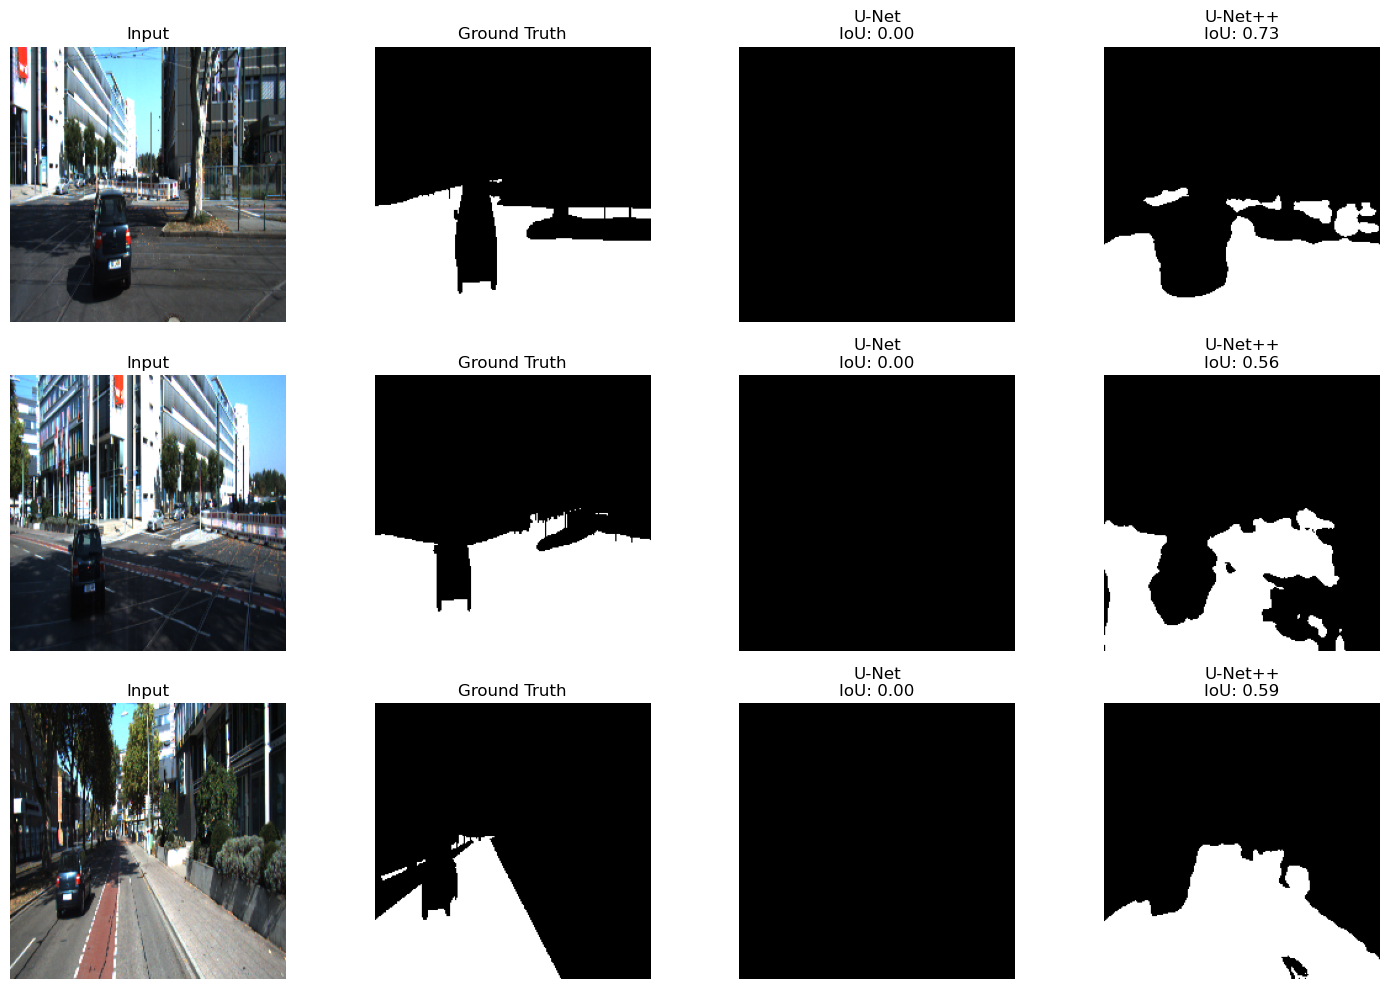

In [59]:
# ==========================================
# 3. 최종 비교 및 시각화 함수 (Reporter)
# ==========================================
def compare_models(unet, unetpp, test_loader, device):
    unet.eval()
    unetpp.eval()
    
    scores = {'unet_iou': [], 'unet_biou': [], 'pp_iou': [], 'pp_biou': []}
    
    # 1. 전체 데이터셋 정량 평가
    print("\n📊 Evaluating Models on Test Set...")
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() == 3: targets = targets.unsqueeze(1)
            
            # Inference
            out_unet = torch.sigmoid(unet(inputs))
            out_pp = torch.sigmoid(unetpp(inputs))
            
            # Batch 내 개별 계산
            for i in range(inputs.size(0)):
                scores['unet_iou'].append(calculate_iou_score(out_unet[i], targets[i]))
                scores['unet_biou'].append(calculate_boundary_iou_score(out_unet[i], targets[i]))
                scores['pp_iou'].append(calculate_iou_score(out_pp[i], targets[i]))
                scores['pp_biou'].append(calculate_boundary_iou_score(out_pp[i], targets[i]))

    # 평균 점수 출력
    print(f"\n🏆 Final Score Report")
    print(f"U-Net   | Mean IoU: {np.mean(scores['unet_iou']):.4f} | Mean Boundary IoU: {np.mean(scores['unet_biou']):.4f}")
    print(f"U-Net++ | Mean IoU: {np.mean(scores['pp_iou']):.4f} | Mean Boundary IoU: {np.mean(scores['pp_biou']):.4f}")

    # 2. 정성 평가 (시각화) - 랜덤 3장
    print("\n🎨 Visualizing Results...")
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    if targets.dim() == 3: targets = targets.unsqueeze(1)
    
    with torch.no_grad():
        out_u = torch.sigmoid(unet(inputs))
        out_pp = torch.sigmoid(unetpp(inputs))
    
    plt.figure(figsize=(15, 10))
    for i in range(min(3, inputs.size(0))):
        # Input
        plt.subplot(3, 4, i*4 + 1)
        img = inputs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Input")
        plt.axis('off')
        
        # GT
        plt.subplot(3, 4, i*4 + 2)
        plt.imshow(targets[i].cpu().squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        # U-Net
        plt.subplot(3, 4, i*4 + 3)
        plt.imshow(out_u[i].cpu().squeeze() > 0.5, cmap='gray')
        plt.title(f"U-Net\nIoU: {scores['unet_iou'][i]:.2f}")
        plt.axis('off')
        
        # U-Net++
        plt.subplot(3, 4, i*4 + 4)
        plt.imshow(out_pp[i].cpu().squeeze() > 0.5, cmap='gray')
        plt.title(f"U-Net++\nIoU: {scores['pp_iou'][i]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. 메인 실행 블록 (Run Everything)
# ==========================================
if __name__ == "__main__":
    # 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 8  # U-Net++ 메모리 고려하여 8 권장
    EPOCHS = 50     # 시간 관계상 5 (충분한 학습을 위해선 20~50 권장)

    # 데이터 로더 준비
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 1. U-Net 학습
    model_u = UNet(input_channels=3, output_channels=1).to(device)
    model_u = train_model("U-Net", model_u, train_loader, EPOCHS, device)

    # 2. U-Net++ 학습
    model_pp = NestedUNet(in_channels=3, out_channels=1).to(device)
    model_pp = train_model("U-Net++", model_pp, train_loader, EPOCHS, device)

    # 3. 최종 비교 (모든 목표 달성 확인)
    compare_models(model_u, model_pp, test_loader, device)